In [12]:
!pip install datasets

In [34]:
from datasets import load_dataset

dataset = load_dataset("wikipedia", "20220301.simple")

In [35]:
print(dataset.column_names)
print("------------------")
print(dataset)

formatted_texts = []
for row in dataset['train']:
    text = row['text']
    formatted_text = f"{text}"
    formatted_texts.append(formatted_text)

print("------------------")

print(len(formatted_texts))

{'train': ['id', 'url', 'title', 'text']}
------------------
DatasetDict({
    train: Dataset({
        features: ['id', 'url', 'title', 'text'],
        num_rows: 205328
    })
})
------------------
205328


In [36]:
num_oraciones = len(formatted_texts) // 4
formatted_texts = formatted_texts[:num_oraciones]
print(len(formatted_texts))

num_oraciones = len(formatted_texts) // 4
formatted_texts = formatted_texts[:num_oraciones]
print(len(formatted_texts))

num_oraciones = len(formatted_texts) // 4
formatted_texts = formatted_texts[:num_oraciones]
print(len(formatted_texts))

num_oraciones = len(formatted_texts) // 2
formatted_texts = formatted_texts[:num_oraciones]
print(len(formatted_texts))

51332
12833
3208
1604


In [37]:
# Inicializar una lista vacía para almacenar las oraciones divididas en palabras
oraciones_divididas = []
# Iterar sobre todas las oraciones en la lista original
for oracion in formatted_texts:
    # Dividir la oración en palabras
    palabras = oracion.split()
    # Agregar la lista de palabras a la lista de oraciones divididas en palabras
    oraciones_divididas.append(palabras)

for i, oracion in enumerate(oraciones_divididas):
    if i > 10:break
    print(oracion)

['April', 'is', 'the', 'fourth', 'month', 'of', 'the', 'year', 'in', 'the', 'Julian', 'and', 'Gregorian', 'calendars,', 'and', 'comes', 'between', 'March', 'and', 'May.', 'It', 'is', 'one', 'of', 'four', 'months', 'to', 'have', '30', 'days.', 'April', 'always', 'begins', 'on', 'the', 'same', 'day', 'of', 'week', 'as', 'July,', 'and', 'additionally,', 'January', 'in', 'leap', 'years.', 'April', 'always', 'ends', 'on', 'the', 'same', 'day', 'of', 'the', 'week', 'as', 'December.', "April's", 'flowers', 'are', 'the', 'Sweet', 'Pea', 'and', 'Daisy.', 'Its', 'birthstone', 'is', 'the', 'diamond.', 'The', 'meaning', 'of', 'the', 'diamond', 'is', 'innocence.', 'The', 'Month', 'April', 'comes', 'between', 'March', 'and', 'May,', 'making', 'it', 'the', 'fourth', 'month', 'of', 'the', 'year.', 'It', 'also', 'comes', 'first', 'in', 'the', 'year', 'out', 'of', 'the', 'four', 'months', 'that', 'have', '30', 'days,', 'as', 'June,', 'September', 'and', 'November', 'are', 'later', 'in', 'the', 'year.', 

In [39]:
import collections
from collections import Counter, OrderedDict
from torchtext.vocab import vocab

def make_vocab(oraciones,min_freq=1):
  #Comprueba que oraciones es una lista de listas
  if oraciones and isinstance(oraciones[0], list):
    #Transforma una lista anidada en una lista simple
    tokens = [token for line in oraciones for token in line]
  counter_obj = collections.Counter()
  counter_obj.update(tokens)
  sorted_by_freq_tuples = sorted(counter_obj.items(), key=lambda x: x[1], reverse=True)
  ordered_dict = OrderedDict(sorted_by_freq_tuples)
  vocabulario = vocab(ordered_dict, min_freq=min_freq)
  return vocabulario, ordered_dict

vocab_completo, _ = make_vocab(oraciones_divididas)
vocab_min_freq_10, ordered_dict = make_vocab(oraciones_divididas,10)

print("El tamaño del vocabulario sin frecuencia mínima es",len(vocab_completo))
print("El tamaño del vocabulario con frecuencia mínima de 10 es",len(vocab_min_freq_10))

El tamaño del vocabulario sin frecuencia mínima es 109065
El tamaño del vocabulario con frecuencia mínima de 10 es 9739


In [40]:
def get_most_frequent_in_vocab(vocab, ordered_dic, n):
  return [(item,ordered_dic[item])
      for i, item in enumerate(ordered_dic)
      if vocab.__contains__(item) and i<n]

get_most_frequent_in_vocab(vocab_min_freq_10,ordered_dict,10)

[('the', 51728),
 ('of', 32483),
 ('and', 24746),
 ('in', 19820),
 ('a', 18490),
 ('is', 18372),
 ('to', 16771),
 ('The', 10811),
 ('are', 8759),
 ('–', 7751)]

In [41]:
import random
import math
def subsample(oraciones):
  """Subsample high-frequency words."""
  #Comprueba que oraciones es una lista de listas
  if oraciones and isinstance(oraciones[0], list):
    #Transforma una lista anidada en una lista simple
    tokens = [token for line in oraciones for token in line]
  counter_obj = collections.Counter()
  counter_obj.update(tokens)
  num_tokens = sum(counter_obj.values())

  # Devuelve true si hay que conservar el token
  def keep(token):
      return(random.uniform(0, 1) <
              math.sqrt(1e-4 / counter_obj[token] * num_tokens))

  return ([[token for token in line if keep(token)] for line in oraciones],
          counter_obj)


oraciones_divididas_subsampled, counter = subsample(oraciones_divididas)

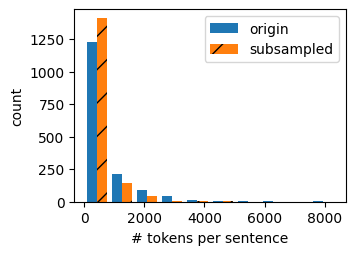

In [42]:
from matplotlib import pyplot as plt

def show_list_len_pair_hist(legend, xlabel, ylabel, xlist, ylist):
    """Plot the histogram for list length pairs."""
    plt.rcParams['figure.figsize'] = (3.5, 2.5)
    _, _, patches = plt.hist(
        [[len(l) for l in xlist], [len(l) for l in ylist]])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    for patch in patches[1].patches:
        patch.set_hatch('/')
    plt.legend(legend)

show_list_len_pair_hist(['origin', 'subsampled'], '# tokens per sentence',
                            'count', oraciones_divididas, oraciones_divididas_subsampled);

In [43]:
def compare_counts(token):
    return (f'# of "{token}": '
            f'before={sum([l.count(token) for l in oraciones_divididas])}, '
            f'after={sum([l.count(token) for l in oraciones_divididas_subsampled])}')

print(compare_counts('the'))
print(compare_counts('of'))
print(compare_counts('and'))

# of "the": before=51728, after=2280
# of "of": before=32483, after=1865
# of "and": before=24746, after=1543


In [44]:
corpus = [[vocab_min_freq_10[x] for x in line if vocab_min_freq_10.__contains__(x)]
          for line in oraciones_divididas_subsampled if line != []]
corpus[:3]

[[1316,
  736,
  2061,
  1942,
  325,
  89,
  26,
  5,
  814,
  1349,
  105,
  886,
  88,
  227,
  639,
  13,
  823,
  338,
  1048,
  17,
  8915,
  5805,
  600,
  8324,
  5,
  377,
  5533,
  325,
  83,
  8916,
  311,
  1316,
  736,
  325,
  214,
  131,
  276,
  814,
  25,
  321,
  3219,
  125,
  140,
  268,
  886,
  0,
  639,
  823,
  1048,
  88,
  227,
  270,
  601,
  5055,
  570,
  1072,
  2752,
  2198,
  8917,
  4642,
  3862,
  419,
  1005,
  17,
  227,
  639,
  1,
  792,
  601,
  823,
  419,
  1,
  792,
  436,
  155,
  419,
  2976,
  0,
  639,
  792,
  601,
  823,
  419,
  0,
  792,
  436,
  155,
  115,
  1539,
  155,
  1005,
  88,
  227,
  639,
  792,
  601,
  823,
  115,
  1539,
  1435,
  2976,
  227,
  639,
  84,
  792,
  1539,
  105,
  1005,
  227,
  639,
  125,
  111,
  601,
  115,
  1539,
  201,
  823,
  419,
  145,
  486,
  436,
  1539,
  201,
  155,
  419,
  2976,
  125,
  486,
  601,
  115,
  1539,
  823,
  419,
  486,
  3394,
  736,
  0,
  455,
  5056,
  1162,
  5534,
  7

In [45]:
def get_centers_and_contexts(corpus, max_window_size):
  """Return center words and context words in skip-gram."""
  centers, contexts = [], []
  for line in corpus:
    # Para formar un par de "palabra central--palabra de contexto",
    # cada oración debe tener al menos 2 palabras
    if len(line) < 2:
      continue
    centers += line
    for i in range(len(line)):  # Ventana de contexto centrada en `i`
      window_size = random.randint(1, max_window_size)
      indices = list(range(max(0, i - window_size),
                            min(len(line), i + 1 + window_size)))
      # Excluir la palabra central de las palabras de contexto
      indices.remove(i)
      contexts.append([line[idx] for idx in indices])
  return centers, contexts

all_centers, all_contexts = get_centers_and_contexts(corpus, 5)
f'# center-context pairs: {sum([len(contexts) for contexts in all_contexts])}'

'# center-context pairs: 2524719'

In [46]:
class RandomGenerator:
  """Randomly draw among {1, ..., n} according to n sampling weights."""
  def __init__(self, sampling_weights):
    # Exclude
    self.population = list(range(1, len(sampling_weights) + 1))
    self.sampling_weights = sampling_weights
    self.candidates = []
    self.i = 0

  def draw(self):
    if self.i == len(self.candidates):
      # Cache `k` random sampling results
      self.candidates = random.choices(
          self.population, self.sampling_weights, k=10000)
      self.i = 0
    self.i += 1
    return self.candidates[self.i - 1]

In [47]:
def get_negatives(all_contexts, vocab, counter, K):
    """Devuelve palabras ruidosas para muestreo negativo."""
    # Pesos de muestreo para palabras con índices 1, 2, ...
    # (índice 0 es el token <unk> excluido) en el vocabulario
    tokens = vocab.get_itos()
    sampling_weights = [counter[tokens[i]]**0.75
                        for i in range(1, len(tokens))]
    all_negatives, generator = [], RandomGenerator(sampling_weights)
    for contexts in all_contexts:
        negatives = []
        while len(negatives) < len(contexts) * K:
            neg = generator.draw()
            # Las palabras ruidosas no pueden ser de contexto
            if neg not in contexts:
                negatives.append(neg)
        all_negatives.append(negatives)
    return all_negatives

all_negatives = get_negatives(all_contexts, vocab_min_freq_10, counter, 5)

In [48]:
all_centers[500], all_contexts[500], all_negatives[500]

(8326,
 [2, 455, 671, 1006],
 [145,
  3475,
  1819,
  4,
  3122,
  24,
  691,
  3503,
  2970,
  770,
  3951,
  6644,
  8236,
  5688,
  30,
  3069,
  1339,
  768,
  1659,
  352])

In [49]:
import torch
def collate_batch(data):
  max_len = max(len(c) + len(n) for _, c, n in data)
  centers, contexts_negatives, masks, labels = [], [], [], []
  for center, context, negative in data:
    centers += [center]
    cur_len = len(context) + len(negative)
    contexts_negatives += [context + negative + [0] * (max_len - cur_len)]
    masks += [[1] * cur_len + [0] * (max_len - cur_len)]
    labels += [[1] * len(context) + [0] * (max_len - len(context))]
  return (torch.tensor(centers).reshape((-1, 1)), torch.tensor(
        contexts_negatives), torch.tensor(masks), torch.tensor(labels))

In [50]:
x_1 = (1, [2, 2], [3, 3, 3, 3])
x_2 = (1, [2, 2, 2], [3, 3])
batch = collate_batch((x_1, x_2))

names = ['centers', 'contexts_negatives', 'lengths', 'labels']
for name, data in zip(names, batch):
    print(name, '=', data)

centers = tensor([[1],
        [1]])
contexts_negatives = tensor([[2, 2, 3, 3, 3, 3],
        [2, 2, 2, 3, 3, 0]])
lengths = tensor([[1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0]])
labels = tensor([[1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0]])


In [72]:
def load_data_quijote(batch_size, max_window_size, num_noise_words):
    """Download the PTB dataset and then load it into memory."""
    dataset = load_dataset("wikipedia", "20220301.simple")

    formatted_texts = []
    for row in dataset['train']:
        text = row['text']
        formatted_text = f"{text}"
        formatted_texts.append(formatted_text)

    num_oraciones = len(formatted_texts) // 4
    formatted_texts = formatted_texts[:num_oraciones]
    print(len(formatted_texts))

    num_oraciones = len(formatted_texts) // 4
    formatted_texts = formatted_texts[:num_oraciones]
    print(len(formatted_texts))


    oraciones_divididas = []
    for oracion in formatted_texts:
        palabras = oracion.split()
        oraciones_divididas.append(palabras)

    vocabulario, ordered_dict = make_vocab(oraciones_divididas,10)
    oraciones_quijote_subsampled, counter = subsample(oraciones_divididas)

    corpus = [[vocabulario[x] for x in line if vocabulario.__contains__(x)]
          for line in oraciones_quijote_subsampled if line != []]
    all_centers, all_contexts = get_centers_and_contexts(
        corpus, max_window_size)
    all_negatives = get_negatives(
        all_contexts, vocabulario, counter, num_noise_words)

    class QuijoteDataset(torch.utils.data.Dataset):
        def __init__(self, centers, contexts, negatives):
            assert len(centers) == len(contexts) == len(negatives)
            self.centers = centers
            self.contexts = contexts
            self.negatives = negatives

        def __getitem__(self, index):
            return (self.centers[index], self.contexts[index],
                    self.negatives[index])

        def __len__(self):
            return len(self.centers)

    dataset = QuijoteDataset(all_centers, all_contexts, all_negatives)

    data_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True,
                                      collate_fn=collate_batch)
    return data_iter, vocabulario

In [73]:
data_iter, vocabulario = load_data_quijote(512, 5, 5)
for batch in data_iter:
    for name, data in zip(names, batch):
        print(name, 'shape:', data.shape)
    break

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning: The repository for wikipedia contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/wikipedia
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


51332
12833
centers shape: torch.Size([512, 1])
contexts_negatives shape: torch.Size([512, 60])
lengths shape: torch.Size([512, 60])
labels shape: torch.Size([512, 60])


In [74]:
from torch import nn
embed = nn.Embedding(num_embeddings=20, embedding_dim=4)
print(f'Parametro embedding_weight ({embed.weight.shape}, '
      f'dtype={embed.weight.dtype})')

Parametro embedding_weight (torch.Size([20, 4]), dtype=torch.float32)


In [75]:
embed_size = 100
central_embedding = nn.Embedding(num_embeddings=len(vocabulario),
                                 embedding_dim=embed_size)
context_embedding = nn.Embedding(num_embeddings=len(vocabulario),
                                 embedding_dim=embed_size)
net = nn.Sequential(nn.Embedding(num_embeddings=len(vocabulario),
                                 embedding_dim=embed_size),
                    nn.Embedding(num_embeddings=len(vocabulario),
                                 embedding_dim=embed_size))

In [76]:
class SkipGram(nn.Module):
    def __init__(self, central_embedding, context_embedding):
      super().__init__()
      self.central_embedding = central_embedding
      self.context_embedding = context_embedding

    def forward(self, center, contexts_and_negatives):
      v = central_embedding(center)
      u = context_embedding(contexts_and_negatives)
      pred = torch.bmm(v, u.permute(0, 2, 1))
      return pred

In [77]:
model = SkipGram(central_embedding, context_embedding)
model(torch.ones((2, 1), dtype=torch.long),
          torch.ones((2, 4), dtype=torch.long)).shape

torch.Size([2, 1, 4])

In [78]:
class SigmoidBCELoss(nn.Module):
    # Binary cross-entropy loss with masking
    def __init__(self):
        super().__init__()

    def forward(self, inputs, target, mask=None):
        out = nn.functional.binary_cross_entropy_with_logits(
            inputs, target, weight=mask, reduction="none")
        return out.mean(dim=1)

loss = SigmoidBCELoss()

In [79]:
pred = torch.tensor([[1.1, -2.2, 3.3, -4.4]] * 2)
label = torch.tensor([[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0]])
mask = torch.tensor([[1, 1, 1, 1], [1, 1, 0, 0]])
loss(pred, label, mask) * mask.shape[1] / mask.sum(axis=1)

tensor([0.9352, 1.8462])

In [80]:
def sigmd(x):
    return -math.log(1 / (1 + math.exp(-x)))

print(f'{(sigmd(1.1) + sigmd(2.2) + sigmd(-3.3) + sigmd(4.4)) / 4:.4f}')
print(f'{(sigmd(-1.1) + sigmd(-2.2)) / 2:.4f}')

0.9352
1.8462


In [81]:
import time
def train(net, data_iter, lr, num_epochs, device):
    def init_weights(module):
        if type(module) == nn.Embedding:
            nn.init.xavier_uniform_(module.weight)
    net.apply(init_weights)
    net = net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    L = 0
    N = 0
    for epoch in range(num_epochs):
        start, num_batches = time.time(), len(data_iter)
        for i, batch in enumerate(data_iter):
            optimizer.zero_grad()
            center, context_negative, mask, label = [
                data.to(device) for data in batch]

            pred = net(center, context_negative)
            l = (loss(pred.reshape(label.shape).float(), label.float(), mask)
                     / mask.sum(axis=1) * mask.shape[1])
            l.sum().backward()
            optimizer.step()
            L += l.sum()
            N += l.numel()
        print(f'loss {L / N:.3f}, '
          f'{N / (time.time() - start):.1f} tokens/sec on {str(device)}')

In [82]:
def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu()."""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

lr, num_epochs = 0.002, 20
train(model, data_iter, lr, num_epochs, try_gpu())

loss 0.399, 22386.8 tokens/sec on cuda:0
loss 0.370, 44812.9 tokens/sec on cuda:0
loss 0.354, 67902.0 tokens/sec on cuda:0
loss 0.343, 91761.9 tokens/sec on cuda:0
loss 0.336, 114579.3 tokens/sec on cuda:0
loss 0.330, 136825.8 tokens/sec on cuda:0
loss 0.325, 161483.8 tokens/sec on cuda:0
loss 0.321, 183087.9 tokens/sec on cuda:0
loss 0.318, 200081.9 tokens/sec on cuda:0
loss 0.315, 225511.2 tokens/sec on cuda:0
loss 0.312, 239368.3 tokens/sec on cuda:0
loss 0.310, 267554.6 tokens/sec on cuda:0
loss 0.308, 294586.2 tokens/sec on cuda:0
loss 0.307, 318620.1 tokens/sec on cuda:0
loss 0.305, 337343.9 tokens/sec on cuda:0
loss 0.304, 363363.2 tokens/sec on cuda:0
loss 0.302, 376110.9 tokens/sec on cuda:0
loss 0.301, 401427.4 tokens/sec on cuda:0
loss 0.300, 430202.7 tokens/sec on cuda:0
loss 0.299, 291823.5 tokens/sec on cuda:0


In [128]:
def get_similar_tokens(query_token, k, embed):
    W = embed.weight.data
    assert vocabulario.__contains__(query_token), "El token no está en el vocabulario"
    x = W[vocabulario[query_token]]
    # Compute the cosine similarity. Add 1e-9 for numerical stability
    cos = torch.mv(W, x) / torch.sqrt(torch.sum(W * W, dim=1) *
                                      torch.sum(x * x) + 1e-9)
    topk = torch.topk(cos, k=k+1)[1].cpu().numpy().astype('int32')
    tokens = vocabulario.get_itos()
    for i in topk[1:]:  # Remove the input words
        print(f'cosine sim={float(cos[i]):.3f}: {tokens[i]}')


In [143]:
get_similar_tokens('Valley', 6, net[0])

cosine sim=0.427: (known
cosine sim=0.407: bonsai
cosine sim=0.386: archosaur
cosine sim=0.377: life-style
cosine sim=0.361: Kosovo.
cosine sim=0.358: ICJ


In [124]:
get_similar_tokens('communities', 6, net[0])

cosine sim=0.400: Erik
cosine sim=0.390: Zombies
cosine sim=0.387: conflicts
cosine sim=0.367: Gino
cosine sim=0.365: system:
cosine sim=0.358: tight


In [127]:
get_similar_tokens('computer', 6, net[0])

cosine sim=0.389: Ethernet
cosine sim=0.380: (www.99colors.net)
cosine sim=0.370: Noel
cosine sim=0.358: Effendi
cosine sim=0.350: Winner
cosine sim=0.350: ska


In [118]:
print(len(formatted_texts))

1604


In [119]:
print("El tamaño del vocabulario sin frecuencia mínima es",len(vocab_completo))
print("El tamaño del vocabulario con frecuencia mínima de 10 es",len(vocab_min_freq_10))

El tamaño del vocabulario sin frecuencia mínima es 109065
El tamaño del vocabulario con frecuencia mínima de 10 es 9739


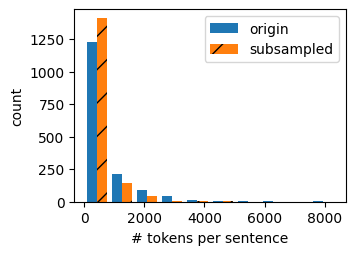

In [120]:
from matplotlib import pyplot as plt

def show_list_len_pair_hist(legend, xlabel, ylabel, xlist, ylist):
    """Plot the histogram for list length pairs."""
    plt.rcParams['figure.figsize'] = (3.5, 2.5)
    _, _, patches = plt.hist(
        [[len(l) for l in xlist], [len(l) for l in ylist]])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    for patch in patches[1].patches:
        patch.set_hatch('/')
    plt.legend(legend)

show_list_len_pair_hist(['origin', 'subsampled'], '# tokens per sentence',
                            'count', oraciones_divididas, oraciones_divididas_subsampled);

In [123]:
def compare_counts(token):
    return (f'# of "{token}": '
            f'before={sum([l.count(token) for l in oraciones_divididas])}, '
            f'after={sum([l.count(token) for l in oraciones_divididas_subsampled])}')

print(compare_counts('the'))
print(compare_counts('of'))
print(compare_counts('and'))
print(compare_counts('in'))
print(compare_counts('a'))
print(compare_counts('is'))
print(compare_counts('to'))
print(compare_counts('The'))
print(compare_counts('are'))

# of "the": before=51728, after=2280
# of "of": before=32483, after=1865
# of "and": before=24746, after=1543
# of "in": before=19820, after=1469
# of "a": before=18490, after=1434
# of "is": before=18372, after=1344
# of "to": before=16771, after=1358
# of "The": before=10811, after=1005
# of "are": before=8759, after=988


In [122]:
get_most_frequent_in_vocab(vocab_min_freq_10,ordered_dict,10)

[('the', 51728),
 ('of', 32483),
 ('and', 24746),
 ('in', 19820),
 ('a', 18490),
 ('is', 18372),
 ('to', 16771),
 ('The', 10811),
 ('are', 8759),
 ('–', 7751)]